In [1]:
import time
import pyvisa
import numpy as np
import requests
import os
import numpy as np
import matplotlib.pyplot as plt
import glob
from pathlib import Path

print("All dependency libraries imported successfully!")

All dependency libraries imported successfully!


In [2]:
# Get current file directory and construct absolute paths
current_dir = Path.cwd()
tools_dir = current_dir / "../Tools"

awg_create_wave_path = tools_dir / "AWG_createWave.ipynb"
bvc_tools_path = tools_dir / "BVC_Tools.ipynb"

%run $awg_create_wave_path
generator = JupyterSignalGenerator()
analyzer = JupyterSignalAnalyzer(generator)


%run $bvc_tools_path
bvcTools = BVCTools()

print("Tool classes imported successfully!")

All dependency libraries imported successfully!
Signal parameter class definition completed!
Jupyter signal generator class definition completed!
Signal analyzer created successfully!
All dependency libraries imported successfully!
Jupyter signal generator class definition completed!
Tool classes imported successfully!


In [3]:
# Configure device parameters
device_ip = "127.0.0.1"

# Sample rate
sample_rate: int = 4 # 4GHz sample rate

show_channel = "CH1"


# DUC parameters
DUC_en = {"CH1": False,
          "CH2": False}
internal_multiple: int = 2 # Interpolation multiple
NCO_freq: float = 0.0 # NCO frequency

show_data_nums = 2

# File path
save_file_path = "/UserSpace"

In [4]:
# Data type mapping
data_type_map = {
    3: np.int8,
    5: np.int16,
    6: np.int16 # QI splicing, each is int16
}
data_type_len_map = {
    np.int8: 1,
    np.int16: 2,
}

In [5]:
result_dir = current_dir / 'Digitizer_result' # Result save path
if not os.path.exists(result_dir):
    os.makedirs(result_dir)

In [6]:
original_list = os.listdir(save_file_path)
# Delete 'WaveList' and 'NSQC'
filtered_list = [item for item in original_list if item not in ['WaveList', 'NSQC']]
# Sort by date and time from newest to oldest
sorted_list = sorted(filtered_list, reverse=True)

In [7]:
if DUC_en[show_channel]:
    file_name = f'{save_file_path}/{sorted_list[0]}/{show_channel}_IQ_0.data' # Raw data path
else:
    file_name = f'{save_file_path}/{sorted_list[0]}/{show_channel}_0.data' # Raw data path

In [8]:
file_obj = open(file_name, 'rb')
head_length = 32 # Header length
file_len = os.path.getsize(file_name) # Total file length
read_len = 0 # Read file length

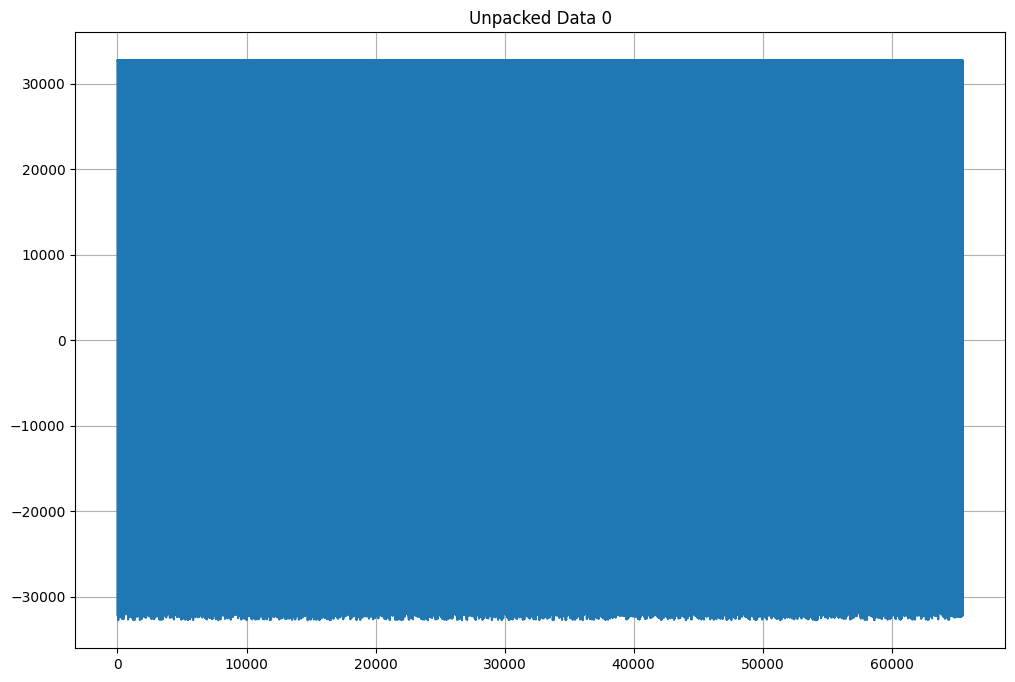

/home/digilab/SUA8000_Examples/remote_control_V3/examples/Digitizer_result/wave_0.bin waveform file saved successfully


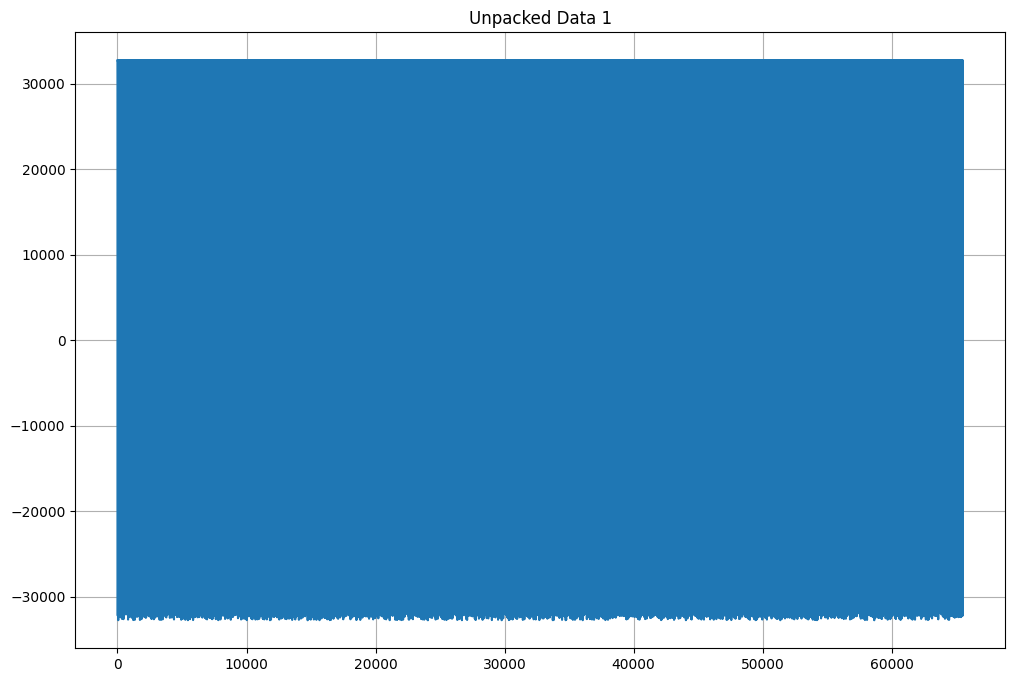

/home/digilab/SUA8000_Examples/remote_control_V3/examples/Digitizer_result/wave_1.bin waveform file saved successfully


In [9]:
for i in range(show_data_nums):
    head_data = file_obj.read(head_length) # Read header
    read_len += head_length
    pack_length = np.frombuffer(head_data[8:12], dtype=np.uint32)[0] # Packet length
    data_length = pack_length - head_length # Data length
    read_len += data_length
    data_type = np.frombuffer(head_data[24:25], dtype=np.int8)[0] # Data type
    data_type = data_type_map.get(data_type, np.int16) # Data type mapping
    prt = np.frombuffer(head_data[4:8], dtype=np.uint32)[0] # Packet count
    data = np.frombuffer(file_obj.read(data_length), dtype=data_type) # Data

    # draw
    plt.plot(data)
    plt.title(f'Unpacked Data {i}')
    plt.grid(True)
    plt.show()

    current_length = len(data)
    target_length = ((current_length - 1) // 16384 + 1) * 16384

    if current_length < target_length:
        padding_length = target_length - current_length
        print(f"Number of zeros to pad: {padding_length}")
        
        # Use np.pad to fill with zeros
        signal_data = np.pad(wave_data, (0, padding_length), mode='constant', constant_values=0)
    else:
        signal_data = data

    # Store waveform
    file_path = f'{result_dir}/wave_{i}.bin'
    signal_data.astype(np.int16).tofile(file_path)
    print(f"{file_path} waveform file saved successfully")
   
    if read_len >= file_len:
        break
file_obj.close()

In [10]:
visa_resource = f'TCPIP::{device_ip}::5555::SOCKET'
        
rm = pyvisa.ResourceManager('@py')

session = rm.open_resource(visa_resource)  # open resource
session.write_termination = '\n'
session.read_termination = '\n'
session.timeout = 50000  # timeout unit: ms
scpi_query = session.query
scpi_write = session.write
scpi_read = session.read

In [11]:
model_info = {}
        
# Device name
device_name = scpi_query(':SYS:DEVice:NAMe? ').replace('\n', '').split(',')
# All module names on the device
module_names = scpi_query(':SYS:DEVice:MODUles?').replace('\n', '').split(',')
for module_name in module_names:
    module_dict = {}
    # Functions supported by this module
    funcs = scpi_query(f':SYS:DEVice:MODUles:FUNC? {module_name}').replace('\n', '').split(',')
    # Query all channels
    in_chnls = []
    out_chnls = []
    for func in funcs:
        if func == 'AWG':
            in_chnls = scpi_query(f':SYS:DEVice:MODUles:CHNLs:OUT? {module_name}').replace('\n', '').split(',')
        if func == 'Digitizer':
            out_chnls = scpi_query(f':SYS:DEVice:MODUles:CHNLs:IN? {module_name}').replace('\n', '').split(',')
    module_dict.setdefault("AWG", in_chnls)
    module_dict.setdefault("Digitizer", out_chnls)
    model_info.setdefault(module_name, module_dict)

print(f"device_name: {device_name}")
print(f"model_info: {model_info}")

device_name: ['TestDevice']
model_info: {'S0_M1210': {'AWG': [], 'Digitizer': []}, 'S0_M2301': {'AWG': [], 'Digitizer': []}, 'S2_M4901': {'AWG': ['CH1', 'CH2'], 'Digitizer': ['CH1', 'CH2']}}


In [12]:
# Module name
module_name = 'S2_M4901'
board_name = 'S0_M1210'
# Channel enable
channel_en = {"CH1": True,
              "CH2": True}

In [13]:
# DUC related configuration
scpi_query(f':AWG:SOURce:WAVE:InternalMultiple {module_name},{internal_multiple}')

for key, value in DUC_en.items():
    scpi_query(f':AWG:OUTPut:DUC:EN {key},True')
    if value:
        scpi_query(f':AWG:OUTPut:DUC:NCOFrequency {key},{NCO_freq}')

In [14]:
# Configure sample rate
scpi_query(f':AWG:SOURce:DAC:SRATe {module_name},{sample_rate}')
bvcTools.sync(device_ip, module_name, board_name)

In [ ]:
seg_list = []

file_pattern = os.path.join(result_dir, "*.bin")
bin_files = glob.glob(file_pattern)

if not bin_files:
    print(f"No .bin files found in directory {result_dir}")
print(f"Found {len(bin_files)} waveform files")

for i, file_path in enumerate(bin_files):
    
    print(f"{i}. {os.path.basename(file_path)}")

    with open(file_path, 'rb') as f:
        file_len = os.path.getsize(file_path) # Total file length

        scpi_query(f':AWG:WAVList:ADDList {module_name},seg{i},{(file_len//2)},Int16')

        files = {
            "file": f
        }
        response = requests.post(f'http://{device_ip}:8000/scpi', data={"scpi": f":AWG:WAVLIST:WAVeform:RTTRACE {module_name},seg{i},0,{file_len//2},\n"}, files=files)
        f.close()

        seg_list.append(f"seg{i}")


Found 2 waveform files
0. wave_0.bin
1. wave_1.bin


In [16]:
# Sub-loop
NSWave_name = "sequence6"
# Create wave table
scpi_query(f':AWG:NSQC:ADD {NSWave_name}')

nsqc = """@nw.kernel
def program(wlist: dict[str, np.ndarray]):
"""
for i, seg in enumerate(seg_list):
    nsqc += f"    seg{i}: nw.ArbWave = nw.init_arbwave(wlist, '{seg}')\n"
nsqc += "    while True:\n"
for i, seg in enumerate(seg_list):
    nsqc += f"        nw.play_arb(seg{i})  # Play segment\n"
nsqc += "    return nw.Kernel()\n"
print(nsqc)

# Wait for external trigger playback
# nw.wait_for_trigger_with_source will modify logic trigger source
nswave_data = {
    "scpi": f":AWG:NSQC:UPload {NSWave_name},\n",
    "nsqc":nsqc
}
# Upload NSWave
response = requests.post(f'http://{device_ip}:8000/scpi', json=nswave_data)
# Compile
for key, value in channel_en.items():
    if value:
        scpi_query(f':AWG:NSQC:COMPile {key},{NSWave_name}')
# Deploy
scpi_query(f':AWG:WAVList:NSQC:COMPile:Send {module_name}')

@nw.kernel
def program(wlist: dict[str, np.ndarray]):
    seg0: nw.ArbWave = nw.init_arbwave(wlist, 'seg0')
    seg1: nw.ArbWave = nw.init_arbwave(wlist, 'seg1')
    while True:
        nw.play_arb(seg0)  # Play segment
        nw.play_arb(seg1)  # Play segment
    return nw.Kernel()



''

In [17]:
# Configure enable
for key, value in channel_en.items():
    rate = scpi_query(f':AWG:OUTPut:EN {key},{value}')
scpi_query(f':SYS:Control:RUN {module_name}')
scpi_query(f':SAT:TRIGger:INTernal:Run {board_name}')

''

In [18]:
time.sleep(10)

In [19]:
scpi_query(f':SAT:TRIGger:INTernal:Stop {board_name}')
scpi_query(f':SYS:Control:STOP {module_name}')

''